# Design MERFISH for 4T1 tumor primary

by Pu Zheng

2023.8.20

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

290082


## Master folder
folder storing all the libraries

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")


- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [3]:
reference_folder = r'/lab/solexa_weissman/puzheng/References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['transcriptome_17.table', 'rtRNA_15.table', 'Mus_musculus.GRCm39.ncrna.fa', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [4]:
# Define the output files
library_folder = os.path.join(library_master_folder, '4T1_MERFISH', 'MF9_4T1Lung_mf4plus')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/designed_probes_idt_oPool.xlsx


## Input files:

In [5]:
# The output codebook filename
#codebook_file = os.path.join(library_folder, 'codebook.csv') # not used in this jupyter
# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp_level1.csv')

print(f"Loading mean_exp for target genes: {target_gene_mean_exp_filename}")
target_gene_mean_exp_df = pd.read_csv(target_gene_mean_exp_filename)
target_gene_mean_exp_df = target_gene_mean_exp_df.set_index(target_gene_mean_exp_df.columns[0])
target_gene_mean_exp_df
# readout file
#readout_savefile = os.path.join(library_folder, 'readouts.csv') # not used in this jupyter

Loading mean_exp for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/marker_gene_mean_exp_level1.csv


Neutrophil      T_NK    B_cell  Macrophage   Myeloid  Malignant  \
Unnamed: 0                                                                    
Chil1         2.334998  0.016876  0.256769    0.477352  0.281874   0.333333   
Cxcr2         4.366702  0.028314  0.510044    1.210326  0.695605   0.512698   
Ly6g          4.404916  0.028877  0.456769    0.399430  0.468580   0.260317   
Asprv1        5.164918  0.045378  0.607278    0.769401  0.616782   0.596825   
Cd79a         0.016273  0.012001  5.780495    0.031359  0.034508   0.015873   
...                ...       ...       ...         ...       ...        ...   
Hoxb5         0.000000  0.000000  0.000291    0.000317  0.000000   0.003175   
Scg2          0.000000  0.000000  0.000000    0.000000  0.000000   0.000000   
Gabrp         0.000505  0.000000  0.000291    0.000000  0.000000   0.009524   
Slc6a2        0.001291  0.000000  0.000000    0.000317  0.000000   0.071429   
Ntrk3         0.001010  0.190324  0.015138    0.002851  0.001090   0.004762   

            Basophil  Endothelial  Hepatocyte  
Unnamed: 0                                     
Chil1       0.199255     0.474474    0.169014  
Cxcr2       1.525140     1.042042    0.366197  
Ly6g        0.243948     1.030030    0.422535  
Asprv1      0.446927     0.870871    0.366197  
Cd79a       0.059590     0.069069    0.021127  
...              ...          ...         ...  
Hoxb5       0.000000     0.075075    0.000000  
Scg2        0.000000     0.000000    0.000000  
Gabrp       0.001862     0.000000    0.000000  
Slc6a2      0.003724     0.012012    0.000000  
Ntrk3       0.009311     0.012012    0.000000  

[175 rows x 9 columns]

You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [6]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


In [7]:
mRNA_fasta_file

'/lab/solexa_weissman/puzheng/References/GRCm39/Transcriptome/Mus_musculus.GRCm39.cdna.all.fa'

## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [8]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Design targeting sequences

## Load required parameters

In [9]:
%%time
# Load the transcriptome as a pandas data frame
cdna = fio.load_transcriptome(mRNA_fasta_file, None)
ncrna = fio.load_transcriptome(ncRNA_fasta_file, None)
transcriptome = cdna#pd.concat([cdna, ncrna])
#transcriptome = fio.load_transcriptome(mRNA_fasta_file, fpkm_tracking_file) #MERFISH version

# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
transcriptome = qc.check_and_standardize_transcriptome(transcriptome, remove_non_standard_columns=True)

# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 116912 transcripts.
116912
Loaded 29245 transcripts.
29245
CPU times: user 2.32 s, sys: 292 ms, total: 2.61 s
Wall time: 2.61 s


# Load gene-selection

## Loading ends here

# Design targeting sequences

In [10]:
# Modify transcriptome to add information:
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037548.16', 'gene_short_name'] = 'H2-DMb2'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037649.11', 'gene_short_name'] = 'H2-DMa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000112023.2', 'gene_short_name'] = 'Lilr4b'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000079547.5', 'gene_short_name'] = 'H2-DMb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000060586.12', 'gene_short_name'] = 'H2-Eb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000073421.7', 'gene_short_name'] = 'H2-Ab1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000036594.16', 'gene_short_name'] = 'H2-Aa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000041538.17', 'gene_short_name'] = 'H2-Ob'


# replace gene-list:
replace_dict = {'Tcrg-C1':'Trgc1', 'Tcrg-C2':'Trgc2', 'Tcrg-C4':'Trgc4', 'Sept1':'Septin1', 'H2afy':'Macroh2a2','Qk':'Qki',
                'Hist1h1b':'H1f5','Fam129b':'Niban2','Sept3':'Septin3',
                'Hist1h2ab':'H2ac4',
                'Il1f9':'Il36g','Cd163l1':'Scart1','Hist1h2af':'H2ac10',
                'Fam71f2':'Garin1a','Hist1h3c':'H3c3','Ero1l':'Ero1a','Fam129c':'Niban3',
                'Gm14548':'Pira12','Ptprg':'PTPRG',
               }
target_gene_mean_exp_df.rename(index=replace_dict, inplace=True)

# check if all exists
for _gene in list(target_gene_mean_exp_df.index):
    # Let's have a look at the transcripts of the FLNA gene
    _transcripts = transcriptome[transcriptome['gene_short_name'] == _gene].sort_values('FPKM', ascending=False)
    if len(_transcripts) == 0:
        print(_gene, len(_transcripts))
    break

In [11]:
gene_ids = target_gene_mean_exp_df.index.values

In [12]:
len(gene_ids)

175

In [13]:
np.save(os.path.join(library_folder, 'replace_dict.npy'), replace_dict, allow_pickle=True)

## Initialize probe_dict

In [14]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(gene_ids, transcriptome, 'gene_short_name', K=30)
#if len(transcript_ids) == len(gene_ids):
#    # Select the transcripts that we want to target
#    # The target transcripts are already defined in the codebook
#    p_d.select_transcripts_by_ids(probe_dict, transcript_ids)
# Init
p_d.print_probe_dict(probe_dict)

Found 828 transcripts for 175 target genes.
Gene	Transcript	N_probes
Trdc
	ENSMUST00000196323.2	3836
Ighd
	ENSMUST00000194162.6	1777
	ENSMUST00000192250.2	773
Klhl14
	ENSMUST00000122333.2	4394
	ENSMUST00000049105.11	3989
Tmem252
	ENSMUST00000057243.6	5005
Gpr141
	ENSMUST00000065335.3	3404
	ENSMUST00000222664.2	617
	ENSMUST00000222772.2	1502
	ENSMUST00000221268.2	1305
Dab2
	ENSMUST00000159552.2	613
	ENSMUST00000078019.13	3764
	ENSMUST00000159046.2	339
	ENSMUST00000161040.8	1069
	ENSMUST00000162140.2	1377
	ENSMUST00000080880.12	4634
	ENSMUST00000110663.9	2725
	ENSMUST00000161812.8	2681
	ENSMUST00000160134.8	1345
	ENSMUST00000159490.8	364
	ENSMUST00000162094.3	708
	ENSMUST00000163082.2	2005
	ENSMUST00000161558.2	447
	ENSMUST00000110664.9	4421
Epcam
	ENSMUST00000235125.2	571
	ENSMUST00000234009.2	875
	ENSMUST00000234354.2	552
	ENSMUST00000234623.2	1716
	ENSMUST00000053577.9	2011
Msh2
	ENSMUST00000024967.14	3254
	ENSMUST00000174240.2	1723
	ENSMUST00000173097.8	2473
	ENSMUST00000172855.2	601

## Based on gff3 reference, keep only the protein-coding isoforms:

In [15]:
# For the selected gene_ids, laod gff3
from ChromAn.src.sequence_tools.reference_io import gff3_reader
gff3_ref = gff3_reader(gff3_file, save=True, save_filename=os.path.join(library_folder, 'gff3_info.pkl'),
                       auto_read=True)

- loading from save_file: /lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/gff3_info.pkl
parsing all gene information
gene:ENSMUSG00000102693
gene:ENSMUSG00000064842
gene:ENSMUSG00000051951
gene:ENSMUSG00000102851
gene:ENSMUSG00000103377
gene:ENSMUSG00000104017
gene:ENSMUSG00000103025
gene:ENSMUSG00000089699
gene:ENSMUSG00000103201
gene:ENSMUSG00000103147
gene:ENSMUSG00000103161
gene:ENSMUSG00000102331
gene:ENSMUSG00000102348
gene:ENSMUSG00000102592
gene:ENSMUSG00000088333
gene:ENSMUSG00000102343
gene:ENSMUSG00000025900
gene:ENSMUSG00000102948
gene:ENSMUSG00000104123
gene:ENSMUSG00000025902
gene:ENSMUSG00000104238
gene:ENSMUSG00000102269
gene:ENSMUSG00000118917
gene:ENSMUSG00000103003
gene:ENSMUSG00000104328
gene:ENSMUSG00000102735
gene:ENSMUSG00000098104
gene:ENSMUSG00000102175
gene:ENSMUSG00002075947
gene:ENSMUSG00000103265
gene:ENSMUSG00000103922
gene:ENSMUSG00000033845
gene:ENSMUSG00000102275
gene:ENSMUSG00000120403
gene:ENSMUSG00000025903
gene:ENSMUSG000

In [16]:
# Test gene-search:
gene_info = gff3_ref._search_gene_by_name('Trcg1')
if len(gene_info) == 1:
    print(gene_info[0]['infos'])
    # load isoforms:
    for _transcript in gene_info[0]['Children']:
        print(_transcript['infos'])
    #print(gene_info[0].keys())

{'ID': 'gene:ENSMUSG00000070298', 'Name': 'Trcg1', 'biotype': 'protein_coding', 'description': 'taste receptor cell gene 1 [Source:MGI Symbol%3BAcc:MGI:3576664]', 'gene_id': 'ENSMUSG00000070298', 'logic_name': 'ensembl_havana_gene_mus_musculus', 'version': '7'}
{'ID': 'transcript:ENSMUST00000093837', 'Parent': 'gene:ENSMUSG00000070298', 'Name': 'Trcg1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23218.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000093837', 'transcript_support_level': '5 (assigned to previous version 4)', 'version': '5'}


In [17]:
for _gene, _ts_2_probes in probe_dict.items():
    # search this gene:
    gene_info = gff3_ref._search_gene_by_name(_gene)[0]
    # only keep protein-coding isoform if this is a protein-coding gene:
    if gene_info['infos']['biotype'] == 'protein_coding':
        # load isoforms:
        for _transcript in gene_info['Children']:
            print(_transcript['infos'])
            if _transcript['infos']['biotype'] != 'protein_coding':
                # delete isoform:
                print(f"delete {_gene}, {_transcript['infos']['transcript_id']}.{_transcript['infos']['version']}, biotype:{_transcript['infos']['biotype']}")
                del(probe_dict[_gene][f"{_transcript['infos']['transcript_id']}.{_transcript['infos']['version']}"])

{'ID': 'transcript:ENSMUST00000049105', 'Parent': 'gene:ENSMUSG00000042514', 'Name': 'Klhl14-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS37748.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000049105', 'transcript_support_level': '1 (assigned to previous version 10)', 'version': '11'}
{'ID': 'transcript:ENSMUST00000122333', 'Parent': 'gene:ENSMUSG00000042514', 'Name': 'Klhl14-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS37748.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000122333', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000057243', 'Parent': 'gene:ENSMUSG00000048572', 'Name': 'Tmem252-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS29713.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000057243', 'transcript_support_level': '1 (assigned to previous version 4)', 'version': '6'}
{'ID': 'transcript:ENSMUST00000065335', 'Parent': 'gene:ENSMUSG00000053101', 'Name': 'Gpr14

In [18]:
# print again
p_d.print_probe_dict(probe_dict)

Gene	Transcript	N_probes
Trdc
	ENSMUST00000196323.2	3836
Ighd
	ENSMUST00000194162.6	1777
	ENSMUST00000192250.2	773
Klhl14
	ENSMUST00000122333.2	4394
	ENSMUST00000049105.11	3989
Tmem252
	ENSMUST00000057243.6	5005
Gpr141
	ENSMUST00000065335.3	3404
	ENSMUST00000222664.2	617
Dab2
	ENSMUST00000078019.13	3764
	ENSMUST00000159046.2	339
	ENSMUST00000161040.8	1069
	ENSMUST00000080880.12	4634
	ENSMUST00000110663.9	2725
	ENSMUST00000161812.8	2681
	ENSMUST00000160134.8	1345
	ENSMUST00000159490.8	364
	ENSMUST00000162094.3	708
	ENSMUST00000163082.2	2005
	ENSMUST00000110664.9	4421
Epcam
	ENSMUST00000235125.2	571
	ENSMUST00000234009.2	875
	ENSMUST00000234623.2	1716
	ENSMUST00000053577.9	2011
Msh2
	ENSMUST00000024967.14	3254
	ENSMUST00000172855.2	601
Camk4
	ENSMUST00000234001.2	497
	ENSMUST00000042868.6	2688
Themis
	ENSMUST00000060409.13	2249
	ENSMUST00000056097.11	5053
	ENSMUST00000105516.9	2332
	ENSMUST00000161345.2	607
Aicda
	ENSMUST00000043301.14	2376
	ENSMUST00000160685.2	1263
Cd200r3
	ENSMUST0000

# First round design

To determine number of probes

### Calculate and filter by probe GC

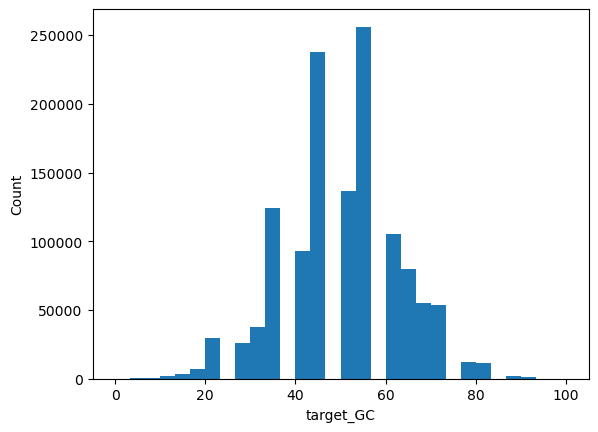

In [19]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

Trdc
	ENSMUST00000196323.2: 2699 / 3836 probes passed the filter 40 < target_GC <  70.
Ighd
	ENSMUST00000194162.6: 1282 / 1777 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000192250.2: 600 / 773 probes passed the filter 40 < target_GC <  70.
Klhl14
	ENSMUST00000122333.2: 2619 / 4394 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000049105.11: 2366 / 3989 probes passed the filter 40 < target_GC <  70.
Tmem252
	ENSMUST00000057243.6: 3257 / 5005 probes passed the filter 40 < target_GC <  70.
Gpr141
	ENSMUST00000065335.3: 1472 / 3404 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000222664.2: 447 / 617 probes passed the filter 40 < target_GC <  70.
Dab2
	ENSMUST00000078019.13: 2085 / 3764 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000159046.2: 194 / 339 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000161040.8: 607 / 1069 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000080880.12: 2757 / 4634 probes passed the filter 40 < 

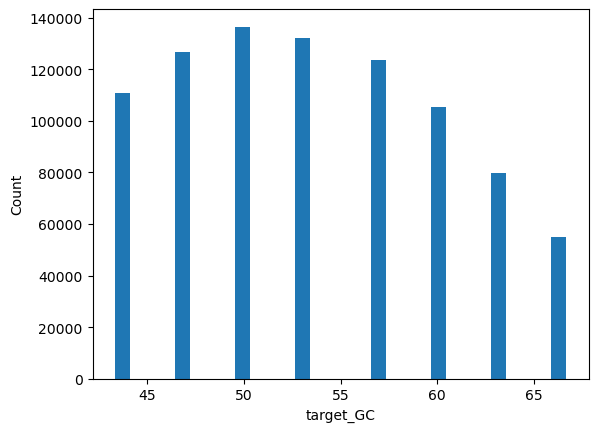

In [20]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

### Calculate and filter by probe Tm

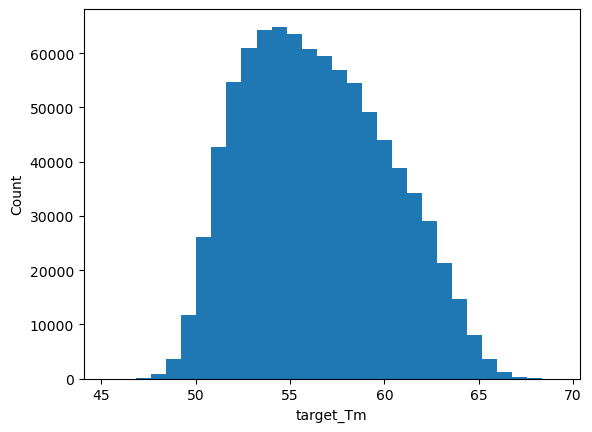

In [21]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

Trdc
	ENSMUST00000196323.2: 2548 / 2699 probes passed the filter 50 < target_Tm <  65.
Ighd
	ENSMUST00000194162.6: 1230 / 1282 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000192250.2: 589 / 600 probes passed the filter 50 < target_Tm <  65.
Klhl14
	ENSMUST00000122333.2: 2572 / 2619 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000049105.11: 2327 / 2366 probes passed the filter 50 < target_Tm <  65.
Tmem252
	ENSMUST00000057243.6: 3175 / 3257 probes passed the filter 50 < target_Tm <  65.
Gpr141
	ENSMUST00000065335.3: 1400 / 1472 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000222664.2: 437 / 447 probes passed the filter 50 < target_Tm <  65.
Dab2
	ENSMUST00000078019.13: 2027 / 2085 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000159046.2: 187 / 194 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000161040.8: 573 / 607 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000080880.12: 2689 / 2757 probes passed the filter 50 < t

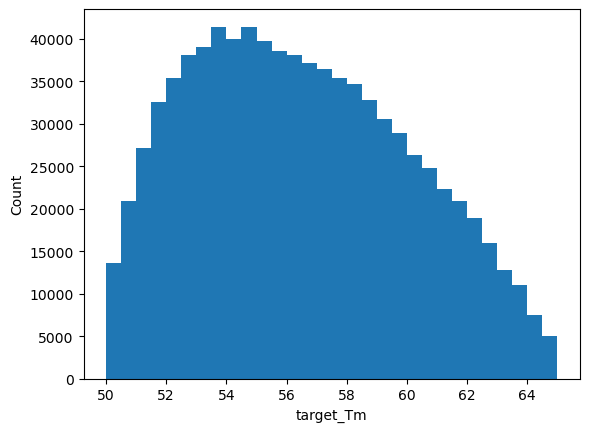

In [22]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

### Calculate off-targets

In [23]:
# Initialize the off-target counting tables
overwrite_ottable = False
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file)
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [24]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, gene_ids, 'gene_short_name', 17)

Generate OTTable for gene Chil1.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene Cxcr2.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Ly6g.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Asprv1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Cd79a.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ebf1.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Ms4a1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Fcmr.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Pax5.
Construct a OTTable using 20/20 transcripts with FPKM > 0.
Generate OTTable for gene Ighd.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Chst3.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTT

In [25]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 116912/116912 transcripts with FPKM > 0.
Processed 10000/116912 sequences.
Processed 20000/116912 sequences.
Processed 30000/116912 sequences.
Processed 40000/116912 sequences.
Processed 50000/116912 sequences.
Processed 60000/116912 sequences.
Processed 70000/116912 sequences.
Processed 80000/116912 sequences.
Processed 90000/116912 sequences.
Processed 100000/116912 sequences.
Processed 110000/116912 sequences.


In [26]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')

Calculate OTs for 0/175 genes.
Calculate OTs for 1/175 genes.
Calculate OTs for 2/175 genes.
Calculate OTs for 3/175 genes.
Calculate OTs for 4/175 genes.
Calculate OTs for 5/175 genes.
Calculate OTs for 6/175 genes.
Calculate OTs for 7/175 genes.
Calculate OTs for 8/175 genes.
Calculate OTs for 9/175 genes.
Calculate OTs for 10/175 genes.
Calculate OTs for 11/175 genes.
Calculate OTs for 12/175 genes.
Calculate OTs for 13/175 genes.
Calculate OTs for 14/175 genes.
Calculate OTs for 15/175 genes.
Calculate OTs for 16/175 genes.
Calculate OTs for 17/175 genes.
Calculate OTs for 18/175 genes.
Calculate OTs for 19/175 genes.
Calculate OTs for 20/175 genes.
Calculate OTs for 21/175 genes.
Calculate OTs for 22/175 genes.
Calculate OTs for 23/175 genes.
Calculate OTs for 24/175 genes.
Calculate OTs for 25/175 genes.
Calculate OTs for 26/175 genes.
Calculate OTs for 27/175 genes.
Calculate OTs for 28/175 genes.
Calculate OTs for 29/175 genes.
Calculate OTs for 30/175 genes.
Calculate OTs for 

### Off-targets to transcriptome

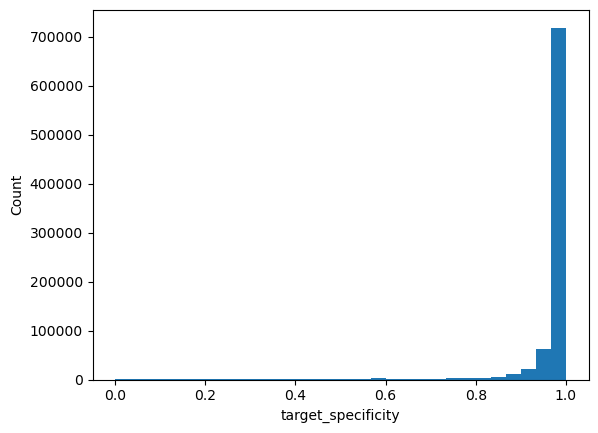

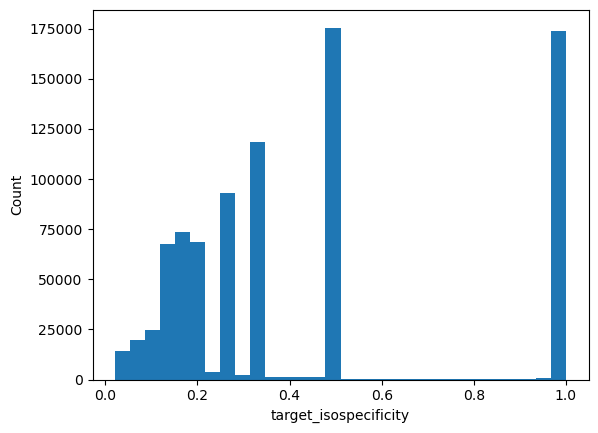

In [27]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

In [28]:
# modify target isospecificity, if only one isoform exist:
for _gene, _transcript_2_df in probe_dict.items():
    if len(_transcript_2_df) == 1:
        for _transcript, _df in _transcript_2_df.items():
            probe_dict[_gene][_transcript]['target_isospecificity'] = 0.01

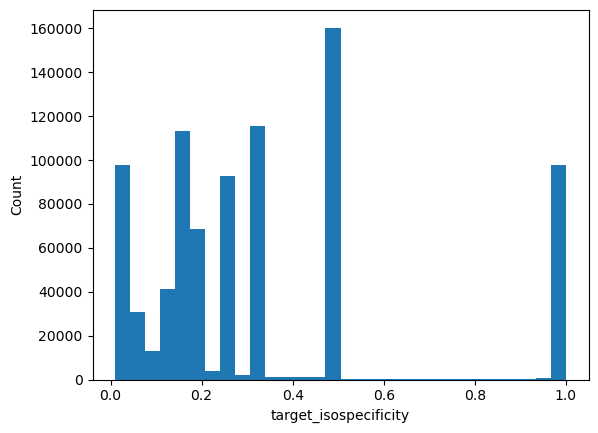

In [29]:
plot.plot_hist(probe_dict, 'target_isospecificity')

Trdc
	ENSMUST00000196323.2: 2097 / 2486 probes passed the filter 0.99 < target_specificity <  inf.
Ighd
	ENSMUST00000194162.6: 946 / 1230 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000192250.2: 495 / 589 probes passed the filter 0.99 < target_specificity <  inf.
Klhl14
	ENSMUST00000122333.2: 2032 / 2572 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000049105.11: 1863 / 2327 probes passed the filter 0.99 < target_specificity <  inf.
Tmem252
	ENSMUST00000057243.6: 2293 / 3069 probes passed the filter 0.99 < target_specificity <  inf.
Gpr141
	ENSMUST00000065335.3: 1099 / 1400 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000222664.2: 311 / 437 probes passed the filter 0.99 < target_specificity <  inf.
Dab2
	ENSMUST00000078019.13: 1609 / 2027 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000159046.2: 171 / 187 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000161040.8: 472 /

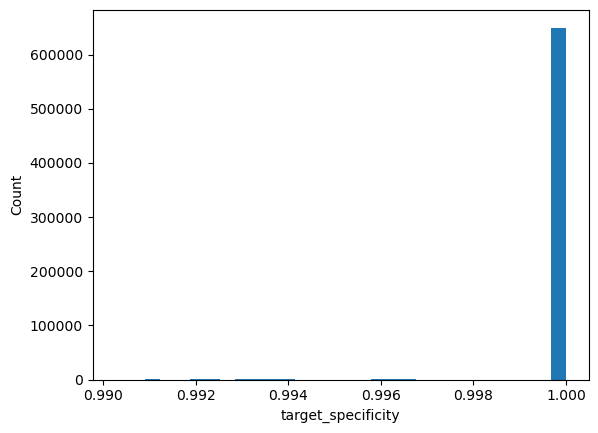

In [30]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

## save probe_dict

In [31]:
import pickle
full_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_full_probe_isoforms.pkl")
print(full_probe_filename)
pickle.dump(probe_dict, open(full_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/2024_10_4_full_probe_isoforms.pkl


## Could restart here

## Select probe isoform

In [32]:
## Select transcript based on length / number of possible probes:
largest_probe_th = 800
median_probe_th = 400

for _gene, _ts_2_pbs in probe_dict.items():
    pb_lens = []
    for _ts, _pbs in _ts_2_pbs.items():
        #print(_ts, len(_pbs))
        pb_lens.append(len(_pbs))
    if len(pb_lens) == 1:
        continue
    # filter
    if np.max(pb_lens) < largest_probe_th and np.median(pb_lens) < median_probe_th:
        print(_gene)
    #break

Ly6g
Ms4a2
Cd3g
Fcer1a


In [33]:
# Isoform selection
sel_pb_dict = {}
largest_probe_th = 1000
isospecificity_th = 0.5
for _gene, _ts_2_pbs in probe_dict.items():
    # case 1, only one transcript
    if len(_ts_2_pbs) == 1:
        sel_pb_dict[_gene] = _ts_2_pbs
    
    pb_lens = [len(_pbs) for _ts, _pbs in _ts_2_pbs.items()]
    general_pb_lens = [np.sum(_pbs['target_isospecificity'] <= isospecificity_th) 
                       for _ts, _pbs in _ts_2_pbs.items()]
    #print(pb_lens, general_pb_lens)
    #break
    # case 2, multiple transcript, now try select nonspecific probes
    # select the transcript with the most common probes
    if np.max(general_pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}
    # case 3: none of transcript has enough common probes: select the one with the most common probes
    elif np.max(pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
    # case 4: all transcripts are short, select teh longest:
    else:
        _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
        
        # check non-specific probes
        _pbs = list(_ts_2_pbs.values())[pb_lens.index(np.max(pb_lens))]
        if np.sum(_pbs['target_isospecificity'] <= isospecificity_th) > largest_probe_th:
            _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
            sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}  
        # select the transcript with the most common probes
    print(_t, len(sel_pb_dict[_gene][_t]))


ENSMUST00000196323.2 2097
ENSMUST00000194162.6 946
ENSMUST00000122333.2 2032
ENSMUST00000057243.6 2293
ENSMUST00000065335.3 1099
ENSMUST00000080880.12 2101
ENSMUST00000053577.9 846
ENSMUST00000024967.14 1751
ENSMUST00000042868.6 1136
ENSMUST00000056097.11 1510
ENSMUST00000043301.14 1274
ENSMUST00000114611.10 653
ENSMUST00000015197.9 1603
ENSMUST00000102802.10 1123
ENSMUST00000000769.14 1090
ENSMUST00000161976.8 1245
ENSMUST00000068592.5 524
ENSMUST00000000312.12 2675
ENSMUST00000023336.10 1162
ENSMUST00000065248.9 784
ENSMUST00000079634.8 651
ENSMUST00000066747.14 1528
ENSMUST00000025004.7 1248
ENSMUST00000062254.4 2030
ENSMUST00000206325.2 1639
ENSMUST00000185234.2 1234
ENSMUST00000034554.9 1166
ENSMUST00000016640.8 1693
ENSMUST00000033820.4 1328
ENSMUST00000086430.5 2959
ENSMUST00000109424.4 1786
ENSMUST00000031246.9 847
ENSMUST00000183482.2 2039
ENSMUST00000027056.12 3748
ENSMUST00000237142.2 1157
ENSMUST00000169928.8 3951
ENSMUST00000163100.8 1965
ENSMUST00000028179.15 767
ENSMUST0

In [34]:
p_d.print_probe_dict(sel_pb_dict) 
# We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trdc
	ENSMUST00000196323.2	2097
Ighd
	ENSMUST00000194162.6	946
Klhl14
	ENSMUST00000122333.2	2032
Tmem252
	ENSMUST00000057243.6	2293
Gpr141
	ENSMUST00000065335.3	1099
Dab2
	ENSMUST00000080880.12	2101
Epcam
	ENSMUST00000053577.9	846
Msh2
	ENSMUST00000024967.14	1751
Camk4
	ENSMUST00000042868.6	1136
Themis
	ENSMUST00000056097.11	1510
Aicda
	ENSMUST00000043301.14	1274
Cd200r3
	ENSMUST00000114611.10	653
Gata2
	ENSMUST00000015197.9	1603
Btla
	ENSMUST00000102802.10	1123
Serpinf1
	ENSMUST00000000769.14	1090
Myc
	ENSMUST00000161976.8	1245
Ifng
	ENSMUST00000068592.5	524
Cdh1
	ENSMUST00000000312.12	2675
Cd96
	ENSMUST00000023336.10	1162
Cd8b1
	ENSMUST00000065248.9	784
Exosc5
	ENSMUST00000079634.8	651
Cd8a
	ENSMUST00000066747.14	1528
Adgre4
	ENSMUST00000025004.7	1248
Clec14a
	ENSMUST00000062254.4	2030
Cd19
	ENSMUST00000206325.2	1639
Scg2
	ENSMUST00000185234.2	1234
Pou2af1
	ENSMUST00000034554.9	1166
Cd274
	ENSMUST00000016640.8	1693
F7
	ENSMUST00000033820.4	1328
Col5a2
	ENSMUS

In [35]:
manual_kept_set1 = list(pd.read_csv(r'/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X/merfish_4T1_genes_removed.csv')['gene'].values)
manual_kept_set1.extend(['Twist1', ])

In [36]:
kept_gene_list = []
removed_gene_list = []
for _gene, _t_2_pbs in sel_pb_dict.items():
    _pbs = list(_t_2_pbs.values())[0]
    if len(_pbs) < 600 and _gene not in list(manual_kept_set1):
        print(_gene, len(_pbs))
        removed_gene_list.append(_gene)
    else:
        kept_gene_list.append(_gene)

In [37]:
len(kept_gene_list)

175

In [38]:
target_gene_mean_exp_df.loc[np.array(kept_gene_list)]

Neutrophil      T_NK    B_cell  Macrophage   Myeloid  Malignant  \
Unnamed: 0                                                                    
Trdc          0.001122  0.210951  0.009607    0.002534  0.000726   0.004762   
Ighd          0.003367  0.003938  1.507132    0.010453  0.007991   0.000000   
Klhl14        0.001347  0.000938  0.416594    0.002217  0.004722   0.000000   
Tmem252       0.000168  0.000375  0.000000    0.000000  0.000726   0.000000   
Gpr141        0.278548  0.011813  0.036099    0.584732  2.111878   0.068254   
...                ...       ...       ...         ...       ...        ...   
Il5           0.000168  0.067129  0.002038    0.002217  0.000726   0.003175   
Rad51         0.114023  0.034877  0.071325    0.015521  0.041773   0.176190   
Dll4          0.000449  0.000188  0.004658    0.001901  0.002906   0.006349   
Itgb6         0.001347  0.000938  0.000000    0.002851  0.000000   0.103175   
Snai1         0.149150  0.003563  0.027365    0.046563  0.037414   0.207937   

            Basophil  Endothelial  Hepatocyte  
Unnamed: 0                                     
Trdc        0.013035     0.018018    0.000000  
Ighd        0.022346     0.024024    0.014085  
Klhl14      0.005587     0.000000    0.000000  
Tmem252     0.000000     0.585586    0.000000  
Gpr141      0.141527     0.201201    0.084507  
...              ...          ...         ...  
Il5         0.000000     0.000000    0.000000  
Rad51       0.033520     0.030030    0.035211  
Dll4        0.000000     0.423423    0.000000  
Itgb6       0.001862     0.000000    0.000000  
Snai1       0.016760     0.066066    0.000000  

[175 rows x 9 columns]

In [39]:
# given these genes, re-calculate expression
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
target_gene_umi_frac_df = pd.read_csv(target_gene_umi_frac_filename)
target_gene_umi_frac_df = target_gene_umi_frac_df.set_index(target_gene_umi_frac_df.columns[0])
target_gene_umi_frac_df.rename(index=replace_dict, inplace=True)
kept_gene_umi_frac_df = target_gene_umi_frac_df.loc[np.array(kept_gene_list)]


In [40]:
figure_folder = os.path.join(library_folder, 'figures')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

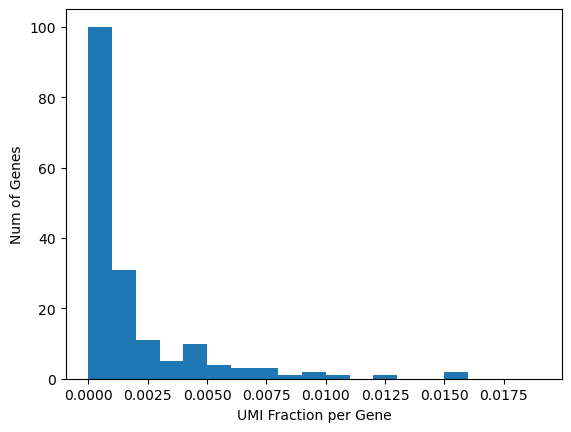

In [41]:
plt.figure()
plt.hist(np.sum(kept_gene_umi_frac_df, 1), bins=np.arange(0, 0.02, 0.001))
plt.xlabel("UMI Fraction per Gene")
plt.ylabel("Num of Genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_UMI_fraction_histogram.png"), 
            transparent=True)
plt.show()

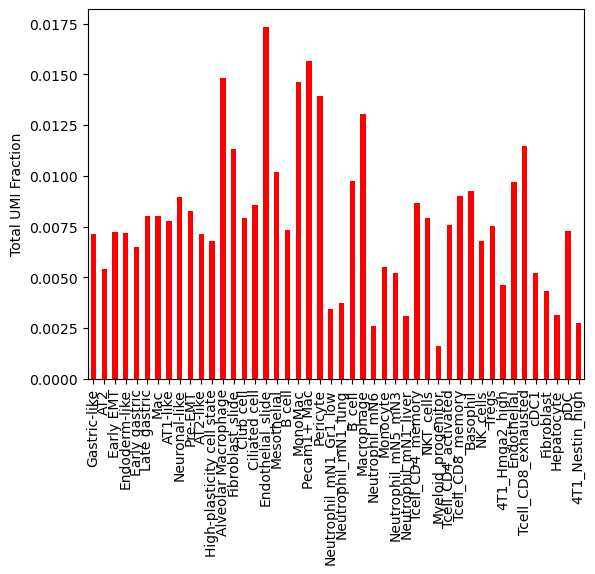

In [42]:
plt.figure()
np.sum(kept_gene_umi_frac_df, 0).plot.bar(color='red')
plt.ylabel("Total UMI Fraction")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_Total_UMI_fraction.png"), 
            transparent=True)
plt.show()

In [43]:
len(kept_gene_list)

175

## determine marker gene group

In [44]:
# load only 4T1 related cell_types:
celltype_num_filename = os.path.join(library_folder, 'celltype_num.csv')
celltype_num = pd.read_csv(celltype_num_filename)

In [45]:
sel_types = target_gene_mean_exp_df.columns
sel_exp_df = target_gene_mean_exp_df[sel_types]

In [46]:
group_2_genes = {_g:[] for _g in sel_types}
for _gene in kept_gene_list:
    _exp = sel_exp_df.loc[_gene]
    _group = _exp.index[np.argmax(_exp)]
    group_2_genes[_group].append(_gene)
marker_gene_num_df = pd.Series({_group: len(_genes) for _group, _genes in group_2_genes.items()})

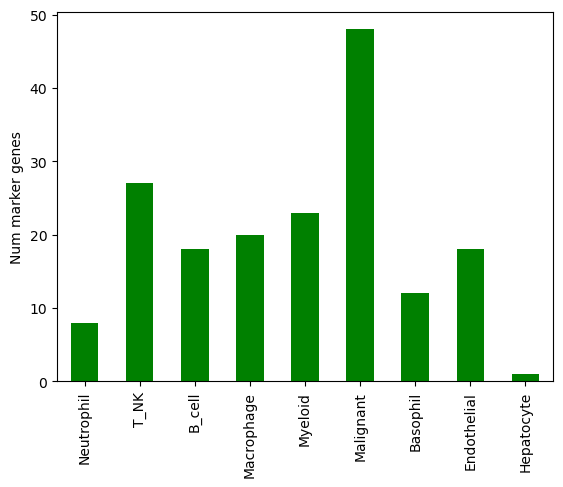

In [47]:
plt.figure()
marker_gene_num_df.plot.bar(color='green')
plt.ylabel("Num marker genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_marker_gene_number.png"), 
            transparent=True)
plt.show()

In [48]:
gene_2_group = {}
for _group, _genes in group_2_genes.items():
    for _g in _genes:
        gene_2_group[_g] = _group

In [49]:
# candidate probes
candidate_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_candidate_probe.pkl")
print(candidate_probe_filename)
pickle.dump(sel_pb_dict, open(candidate_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/2024_10_4_candidate_probe.pkl


In [50]:
# Save the list of genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')

kept_gene_info = ({'Name':kept_gene_list,
                   'Transcript': [list(sel_pb_dict[_gene].keys())[0] for _gene in kept_gene_list],
                   'Num_Candidate_Probes': [len(list(sel_pb_dict[_g].values())[0]) for _g in kept_gene_list],
                  'Group': [gene_2_group[_g] for _g in kept_gene_list],
                  }
                 )
                    
kept_gene_info = pd.DataFrame(kept_gene_info).set_index("Name")
# add info
kept_gene_info = pd.concat([kept_gene_info, target_gene_mean_exp_df.loc[kept_gene_list]], axis=1)
# save
kept_gene_info.to_csv(kept_gene_filename, index=1)
print(kept_gene_filename)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/kept_gene_info.csv


In [51]:
kept_gene_info.head()

Transcript  Num_Candidate_Probes        Group  Neutrophil  \
Trdc     ENSMUST00000196323.2                  2097         T_NK    0.001122   
Ighd     ENSMUST00000194162.6                   946       B_cell    0.003367   
Klhl14   ENSMUST00000122333.2                  2032       B_cell    0.001347   
Tmem252  ENSMUST00000057243.6                  2293  Endothelial    0.000168   
Gpr141   ENSMUST00000065335.3                  1099      Myeloid    0.278548   

             T_NK    B_cell  Macrophage   Myeloid  Malignant  Basophil  \
Trdc     0.210951  0.009607    0.002534  0.000726   0.004762  0.013035   
Ighd     0.003938  1.507132    0.010453  0.007991   0.000000  0.022346   
Klhl14   0.000938  0.416594    0.002217  0.004722   0.000000  0.005587   
Tmem252  0.000375  0.000000    0.000000  0.000726   0.000000  0.000000   
Gpr141   0.011813  0.036099    0.584732  2.111878   0.068254  0.141527   

         Endothelial  Hepatocyte  
Trdc        0.018018    0.000000  
Ighd        0.024024    0.014085  
Klhl14      0.000000    0.000000  
Tmem252     0.585586    0.000000  
Gpr141      0.201201    0.084507

In [52]:
# save removed genes
removed_gene_filename = os.path.join(library_folder, 'removed_genes.csv')
print(removed_gene_filename)
pd.DataFrame({'Name':removed_gene_list}).to_csv(removed_gene_filename, index=None)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF9_4T1Lung_mf4plus/removed_genes.csv


In [53]:
np.unique(kept_gene_info['Group'])

array(['B_cell', 'Basophil', 'Endothelial', 'Hepatocyte', 'Macrophage',
       'Malignant', 'Myeloid', 'Neutrophil', 'T_NK'], dtype=object)

# PAUSE HERE, go to jupyter-3 to design codebook